# Training steps :

1. Install packages
2. Data loading

## 1. Install Packages

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


## 2. Data Loading

In [2]:
import pandas as pd
df = pd.read_csv("./artifacts/input.csv")
df.rename(columns={'price': 'btc_price'}, inplace=True)

# df_stock = pd.read_csv("./artifacts/stock_index_data.csv")
# df_stock.rename(columns={'Datetime': 'timestamp',
#                          'Close' : 'stock_index_close',
#                          'Open' : 'stock_index_open',
#                          'High' : 'stock_price_high',
#                          'Low' : 'stock_price_low'}, inplace=True)

# df_gold = pd.read_csv("./artifacts/gold_prices_euro.csv")
# df_gold.rename(columns={'Datetime': 'timestamp',
#                         'Close': 'close_gold_price'}, inplace=True)


# 3. Preprocessing

In [3]:
from custom.training_functions import process_timestamp,daily_prices,stock_preprocess,gold_preprocess

#Initial preprocessing steps
df = process_timestamp(df)
df = daily_prices(df)

# df_stock = process_timestamp(df_stock)
# df_stock = stock_preprocess(df_stock)
# df_stock = daily_prices(df_stock)

# df_gold = process_timestamp(df_gold)
# df_gold = gold_preprocess(df_gold)
# df_gold = daily_prices(df_gold)


/workspaces/BTC_PREDICTION/dev/custom/training_functions.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.to_datetime(df['timestamp']).dt.floor('H')


In [4]:
# Merge DataFrames on timestamp
# merged_df = pd.merge(df, df_stock, on='timestamp', how='left')
# merged_df1 = pd.merge(merged_df, df_gold, on='timestamp', how='left')

# merged_df_btc_index = merged_df1
# merged_df_btc_index = df

In [5]:
# Define the end date
end_date = pd.to_datetime('2025-12-05')

# Filter the DataFrame to include only rows up to the end date
merged_df_btc_index = df[df['timestamp'] <= end_date]

In [6]:
merged_df_btc_index.tail()

,timestamp,btc_price
289,2025-12-01,77939.0
290,2025-12-02,74329.0
291,2025-12-03,78545.0
292,2025-12-04,80248.0
293,2025-12-05,79148.0


# 3. Additional Feature Engineering

In [7]:
from custom.training_functions import additional_features
merged_df_btc_index = additional_features(merged_df_btc_index)

/workspaces/BTC_PREDICTION/dev/custom/training_functions.py:105: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pct_growth'].fillna(0, inplace=True)  # Fill NaN values with 0


In [8]:
merged_df_btc_index.head()

,btc_price,day_of_week,month,day,pct_growth,pct_price_lag1,pct_price_lag2,pct_price_lag3,pct_price_lag4,pct_price_lag5,pct_rolling_mean_3
timestamp,,,,,,,,,,,
2025-02-20,92663.0,3,2,20,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-21,93680.0,4,2,21,1.097525,1.376292,0.070067,-0.348025,-1.439800,0.131357,0.849282
2025-02-22,91867.0,5,2,22,-1.935312,1.097525,1.376292,0.070067,-0.348025,-1.439800,0.166338
2025-02-23,92326.0,6,2,23,0.499635,-1.935312,1.097525,1.376292,0.070067,-0.348025,-0.121132
2025-02-24,91955.0,0,2,24,-0.401837,0.499635,-1.935312,1.097525,1.376292,0.070067,-0.620787


# 4. Exploratory Data Analysis

While examining the predictor variable we can see that there is a clear trend line. Further, BTC prices by itself may swing a lot with a RMSE of around 6000-8000.
The following trend line of BTC prices is for the past 60 days.

/tmp/ipykernel_25137/1722737801.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


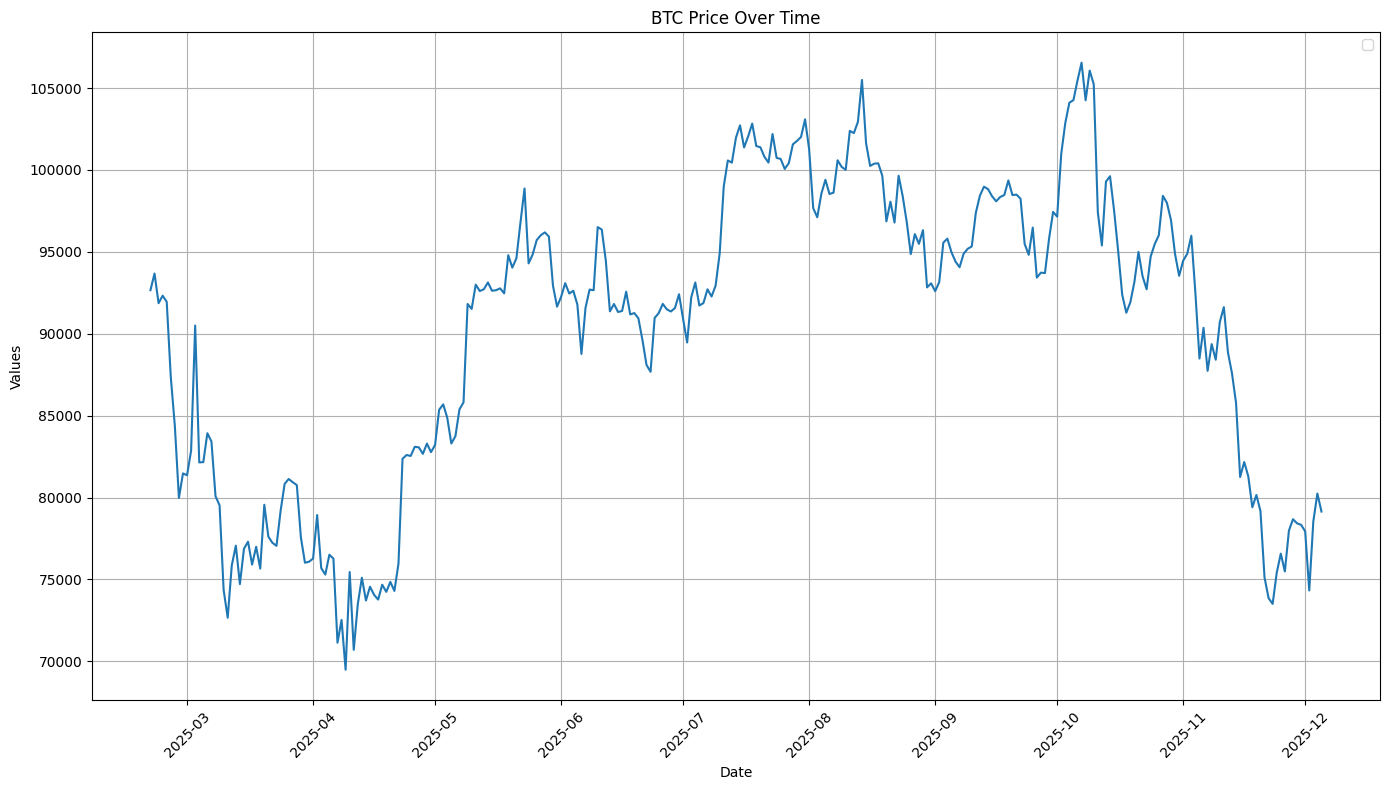

In [9]:
import matplotlib.pyplot as plt
df = merged_df_btc_index
# Plotting
plt.figure(figsize=(14, 8))
plt.plot(df['btc_price'])

# Customize the plot
plt.title('BTC Price Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

# Show the plot
plt.show()

While it is possible to do an ADF test and difference the above graph. I thought of a simpler trick that makese life easier in terms of prediction. 
Instead of predicting the BTC prices itself, predict it's day to day growth fluctuations.

/tmp/ipykernel_25137/3505868963.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


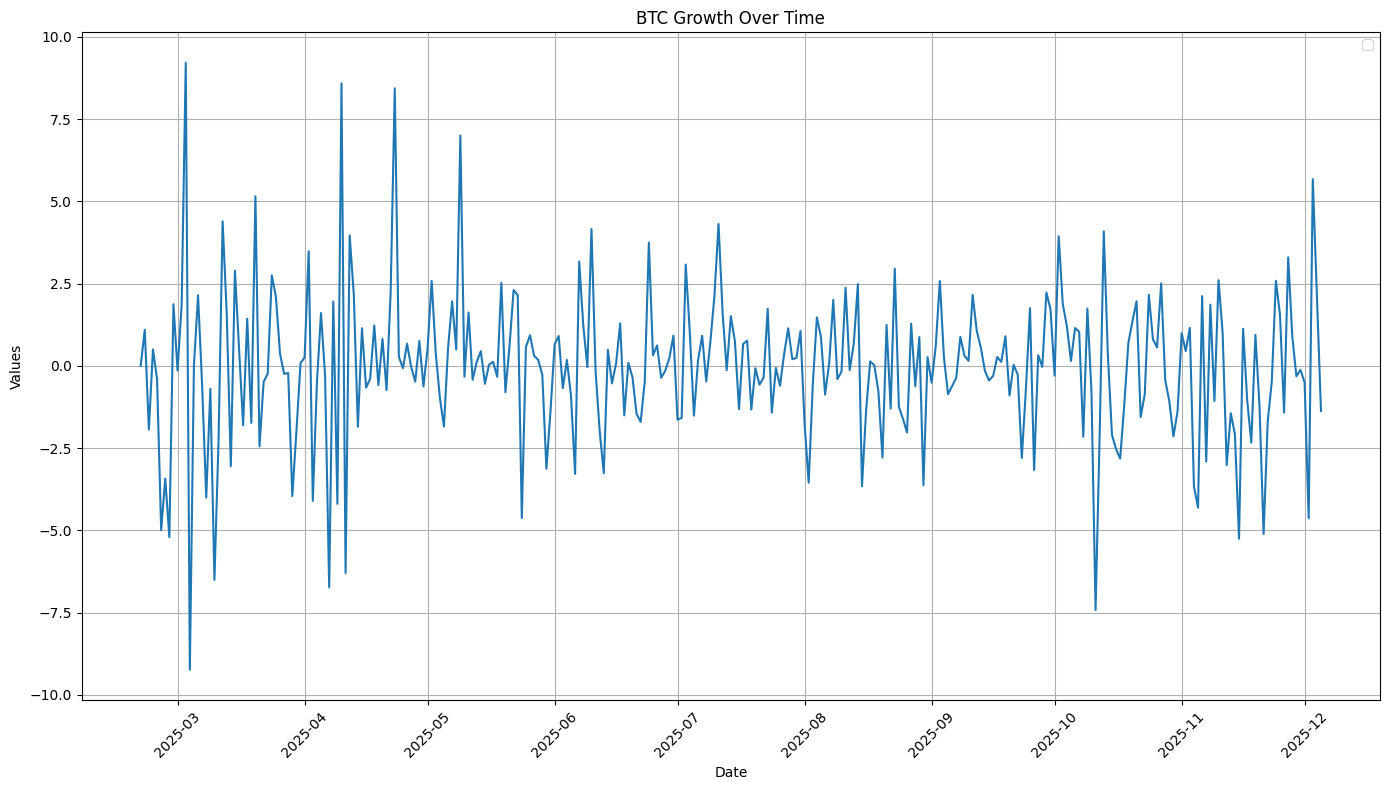

In [10]:
# Plotting
plt.figure(figsize=(14, 8))
plt.plot(df['pct_growth'])
plt.title('BTC Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

# Show the plot
plt.show()

As you can see above, the day on day growth is a much more stationary dataset and conducive to making predictions.

## 3. Modelling

In [11]:
categorical_features = ['day_of_week','month','day']  # Adjust based on your DataFrame

In [12]:
from custom.modelling_functions import prepare_data

X_train, y_train, X_test, y_test, validation_data,test_data,X,y = prepare_data(df)

# Tree Based Algorithm :
The following analysis will show that even though we get a very high R2, the tree based algorithms dont perform well when capturing future trends.

0:	learn: 2.2504027	total: 53.6ms	remaining: 53.5s
50:	learn: 1.9600023	total: 139ms	remaining: 2.58s
100:	learn: 1.7606233	total: 208ms	remaining: 1.85s
150:	learn: 1.6287884	total: 288ms	remaining: 1.62s
200:	learn: 1.5015109	total: 331ms	remaining: 1.31s
250:	learn: 1.3785334	total: 375ms	remaining: 1.12s
300:	learn: 1.2496384	total: 417ms	remaining: 968ms
350:	learn: 1.1023223	total: 459ms	remaining: 848ms
400:	learn: 0.9945773	total: 513ms	remaining: 767ms
450:	learn: 0.8910308	total: 559ms	remaining: 681ms
500:	learn: 0.7974572	total: 598ms	remaining: 596ms
550:	learn: 0.7140290	total: 639ms	remaining: 521ms
600:	learn: 0.6318742	total: 732ms	remaining: 486ms
650:	learn: 0.5582554	total: 798ms	remaining: 428ms
700:	learn: 0.4998853	total: 836ms	remaining: 357ms
750:	learn: 0.4527376	total: 874ms	remaining: 290ms
800:	learn: 0.4088607	total: 924ms	remaining: 230ms
850:	learn: 0.3728005	total: 970ms	remaining: 170ms
900:	learn: 0.3421556	total: 1.02s	remaining: 112ms
950:	learn: 0.

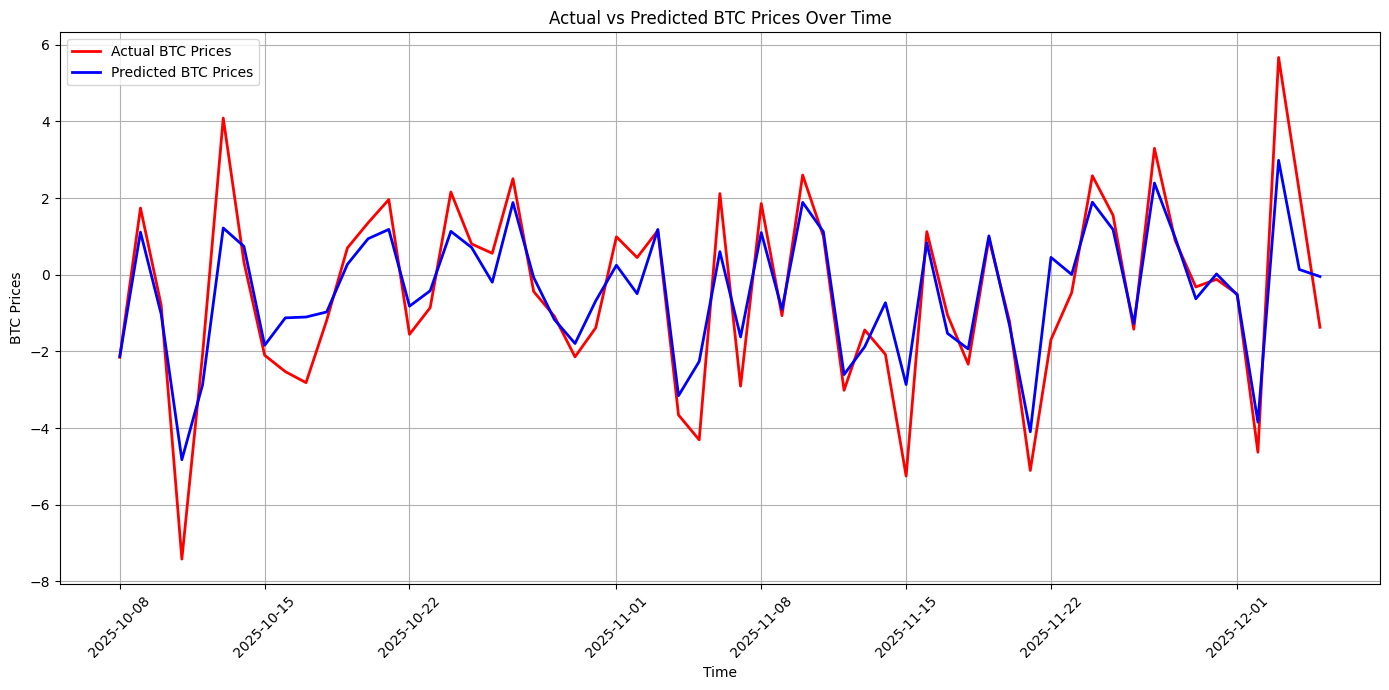

In [13]:
from custom.modelling_functions import train_and_evaluate_catboost

catboost_model, predictions = train_and_evaluate_catboost(test_data,X_train, y_train, X_test, y_test, categorical_features)

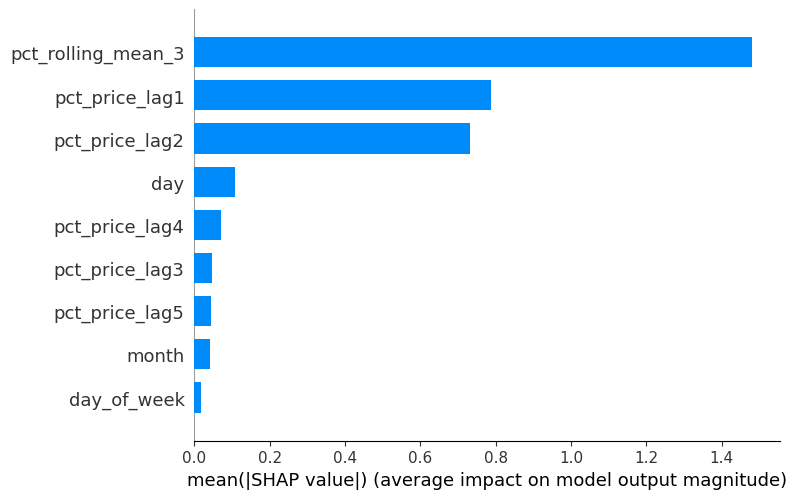

In [14]:
import shap

# Calculate SHAP values
explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_train)

# Plot SHAP values
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Check for Outliers

Outliers detected using Z-score at indices: [ 11  12  49  62  78 233]
Outliers detected using IQR at indices: [  5   7  11  12  18  20  28  46  49  50  62  78  93 233 268 274 285 286]


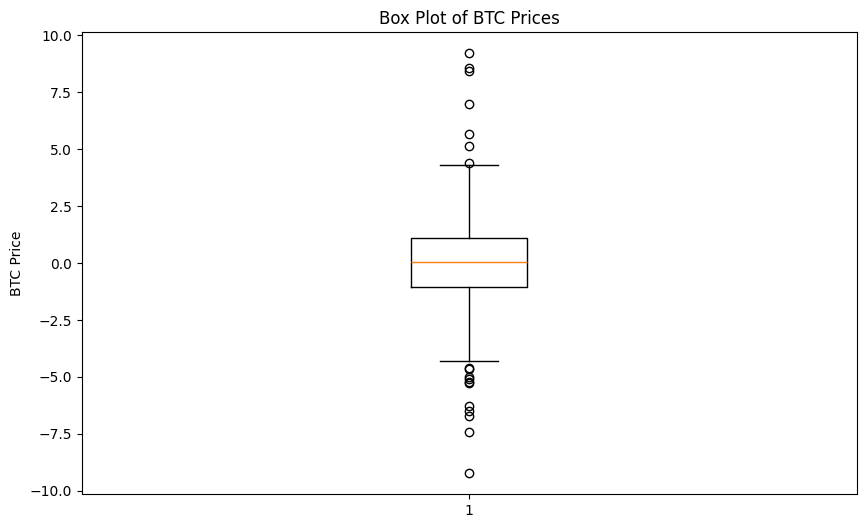

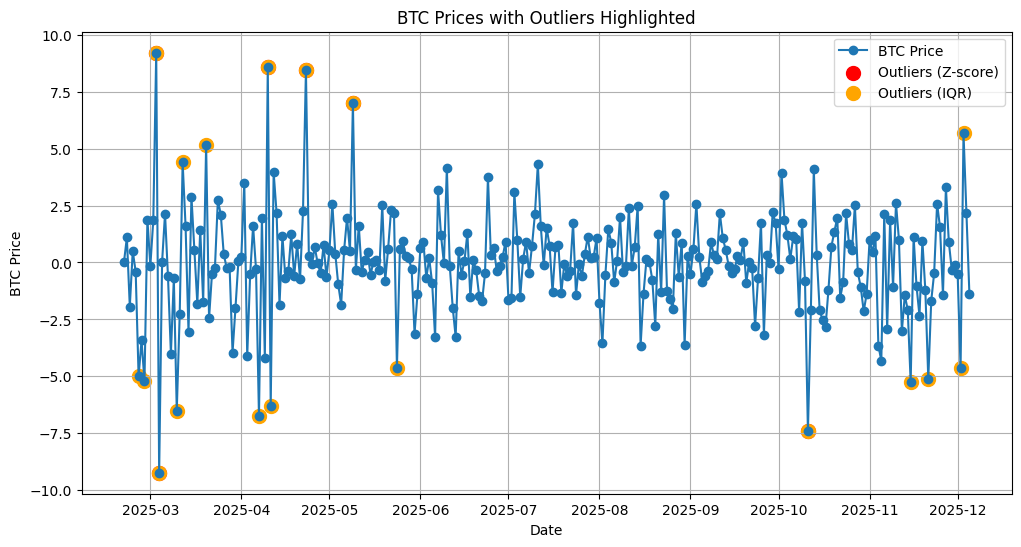

In [15]:
# Method 1: Z-Score Method
import numpy as np
def detect_outliers_z_score(data, threshold=3):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = [(y - mean) / std_dev for y in data]
    return np.where(np.abs(z_scores) > threshold)[0]  # Indices of outliers

# Detect outliers using Z-score
outliers_z = detect_outliers_z_score(df['pct_growth'])
print(f"Outliers detected using Z-score at indices: {outliers_z}")

# Method 2: IQR Method
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((data < lower_bound) | (data > upper_bound))[0]  # Indices of outliers

# Detect outliers using IQR
outliers_iqr = detect_outliers_iqr(df['pct_growth'])
print(f"Outliers detected using IQR at indices: {outliers_iqr}")

# Visualization: Box Plot
plt.figure(figsize=(10, 6))
plt.boxplot(df['pct_growth'])
plt.title('Box Plot of BTC Prices')
plt.ylabel('BTC Price')
plt.show()

# Optionally, visualize outliers
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['pct_growth'], marker='o', label='BTC Price')
plt.scatter(df.index[outliers_z], df['pct_growth'].iloc[outliers_z], color='red', label='Outliers (Z-score)', s=100)
plt.scatter(df.index[outliers_iqr], df['pct_growth'].iloc[outliers_iqr], color='orange', label='Outliers (IQR)', s=100)
plt.title('BTC Prices with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()
plt.grid()
plt.show()

# Multicollinearity

In [16]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# X_train_num = X_train.drop(columns=categorical_features)
# X_train = X_train_num
# # missing_values = X_train_num.isnull().sum()

# # # Check for infinite values
# # infinite_values = np.isinf(X_train_num).sum()

# #Drop rows with missing or infinite values
# X_train_num_cleaned = X_train_num.dropna()
# X_train_num_cleaned = X_train_num_cleaned[~np.isinf(X_train_num_cleaned).any(axis=1)]

# # Calculate VIF on the cleaned DataFrame
# vif_data = pd.DataFrame()
# vif_data['feature'] = X_train_num_cleaned.columns
# vif_data['VIF'] = [variance_inflation_factor(X_train_num_cleaned.values, i) for i in range(X_train_num_cleaned.shape[1])]

# vif_data

from custom.modelling_functions import calculate_vif

# Drop categorical features to focus on numerical ones
X_train_num = X_train.drop(columns=categorical_features)
vif_results = calculate_vif(X_train_num, categorical_features)
vif_results

,feature,VIF
0,pct_price_lag1,1.762572
1,pct_price_lag2,2.021074
2,pct_price_lag3,1.039657
3,pct_price_lag4,1.042026
4,pct_price_lag5,1.024368
5,pct_rolling_mean_3,2.490661


From the above analysis, we see that 
1. pct_stock_index_close
2. pct_stock_price_low
3. pct_stock_index_open

display very high levels of multicollinearity. It makes sense to remove some of them and re-run the model.

Through a simple check of correlation, we can test which feature correlates with which.

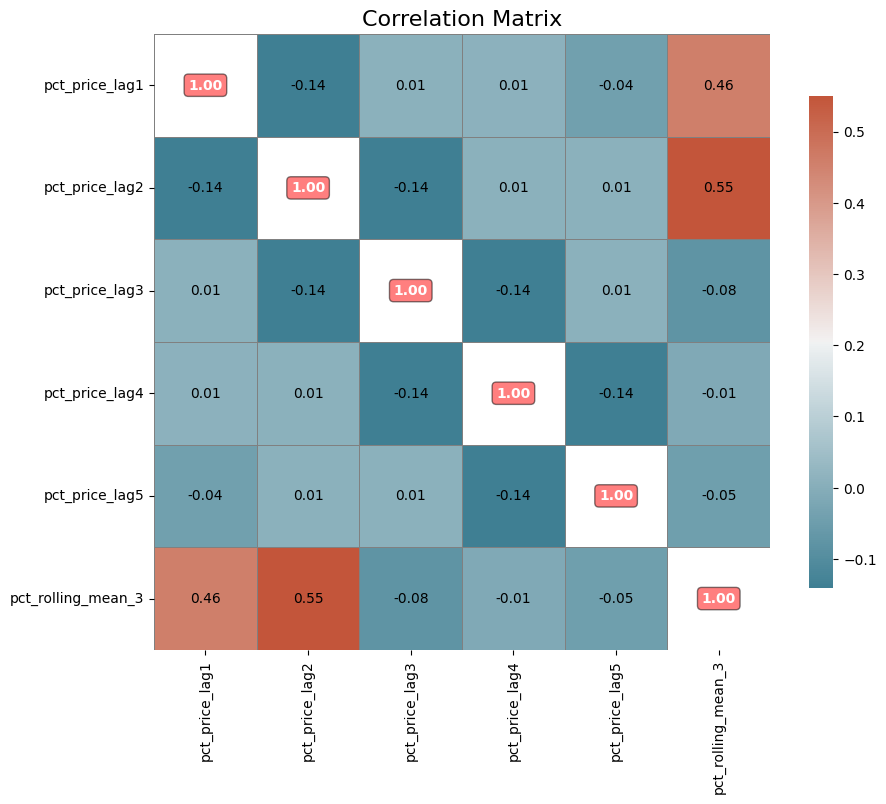

In [17]:
from custom.modelling_functions import plot_correlation_matrix

plot_correlation_matrix(X_train_num)

From the above explanation it is clear that the high vif scores are driven by using different stock indices and it makes sense to choose just one.

# Model fine tuning

In [18]:

# high_vif = ['pct_stock_price_low','pct_stock_price_low','pct_stock_index_open']

# merged_df_btc_index_v2 = merged_df_btc_index.drop(columns=high_vif)
merged_df_btc_index_v2 = merged_df_btc_index

In [19]:
X_train, y_train, X_test, y_test, validation_data,test_data,X,y = prepare_data(merged_df_btc_index_v2)

0:	learn: 2.2504027	total: 4.84ms	remaining: 4.83s
50:	learn: 1.9600023	total: 82.5ms	remaining: 1.53s
100:	learn: 1.7606233	total: 123ms	remaining: 1.09s
150:	learn: 1.6287884	total: 165ms	remaining: 926ms
200:	learn: 1.5015109	total: 219ms	remaining: 869ms
250:	learn: 1.3785334	total: 258ms	remaining: 769ms
300:	learn: 1.2496384	total: 310ms	remaining: 720ms
350:	learn: 1.1023223	total: 377ms	remaining: 697ms
400:	learn: 0.9945773	total: 435ms	remaining: 649ms
450:	learn: 0.8910308	total: 487ms	remaining: 593ms
500:	learn: 0.7974572	total: 532ms	remaining: 530ms
550:	learn: 0.7140290	total: 580ms	remaining: 473ms
600:	learn: 0.6318742	total: 635ms	remaining: 421ms
650:	learn: 0.5582554	total: 676ms	remaining: 362ms
700:	learn: 0.4998853	total: 718ms	remaining: 306ms
750:	learn: 0.4527376	total: 768ms	remaining: 255ms
800:	learn: 0.4088607	total: 822ms	remaining: 204ms
850:	learn: 0.3728005	total: 860ms	remaining: 151ms
900:	learn: 0.3421556	total: 938ms	remaining: 103ms
950:	learn: 0

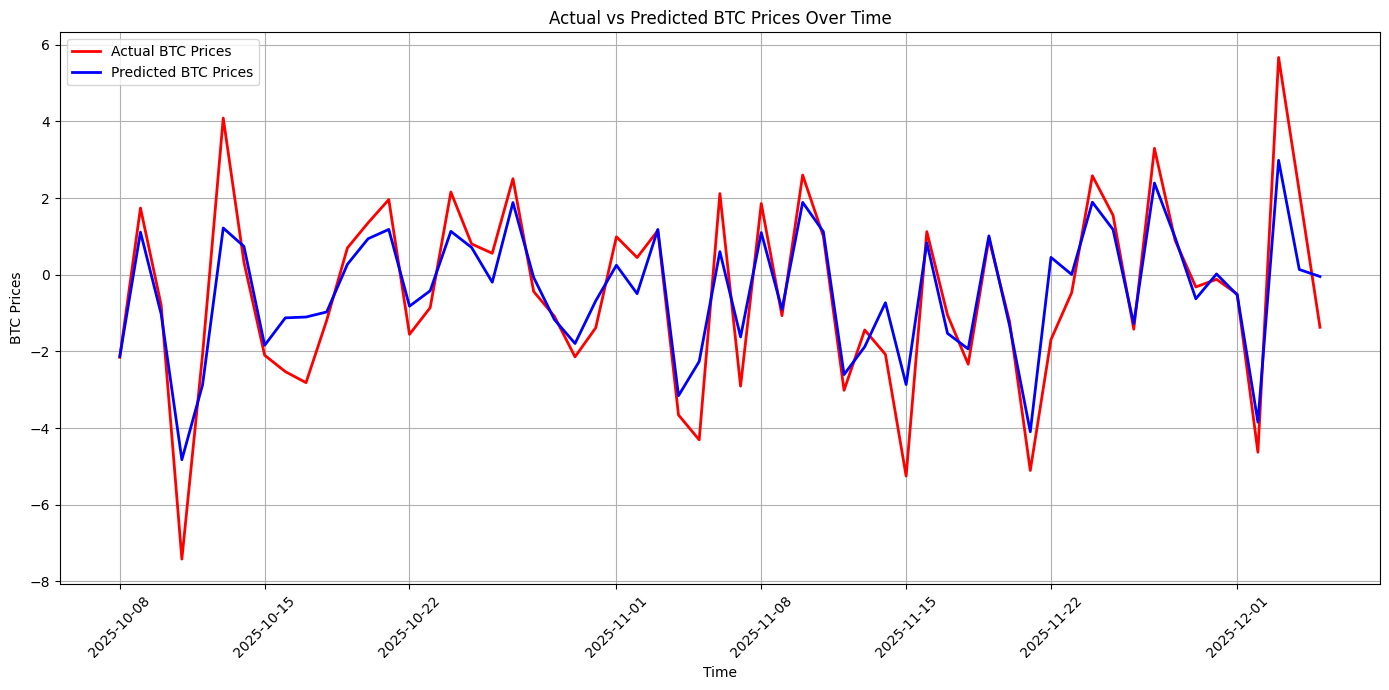

In [20]:
catboost_model, predictions = train_and_evaluate_catboost(test_data,X_train, y_train, X_test, y_test, categorical_features)

As you would notice, there is a clear improvement in the R2 after removing these features.

The next step is to re-test the vif scores. As you can see, all the vif scores are 4 or less. This is tolerable.

In [21]:
import pickle
import os
folder_path = '/workspaces/BTC_PREDICTION/dev/artifacts/' 
# Save the model to a .pkl file in the specified folder
file_path = os.path.join(folder_path, 'catboost_model.pkl')

with open(file_path, 'wb') as file:
    pickle.dump(catboost_model, file)

In [22]:
X_train_num = X_train.drop(columns=categorical_features)
vif_results = calculate_vif(X_train_num, categorical_features)
vif_results

,feature,VIF
0,pct_price_lag1,1.762572
1,pct_price_lag2,2.021074
2,pct_price_lag3,1.039657
3,pct_price_lag4,1.042026
4,pct_price_lag5,1.024368
5,pct_rolling_mean_3,2.490661


# Test for Heteroskedasticity

Heteroskedasticity, a key concept in statistical analysis, occurs when the variance of errors across variables is non-constant. It can undermine the accuracy of regression models

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

def test_heteroscedasticity(X, y):
    """
    Tests for heteroscedasticity using the Breusch-Pagan test.

    Parameters:
    X (pd.DataFrame): The independent variables.
    y (pd.Series): The dependent variable.

    Returns:
    dict: A dictionary containing the test statistic, p-value, and other results.
    """
    # Combine X and y into a single DataFrame to handle missing values
    data = pd.concat([X, y], axis=1)

    # Drop rows with missing or infinite values
    data = data.dropna()
    data = data[~np.isinf(data).any(axis=1)]

    # Separate cleaned data back into X and y
    X_cleaned = data.drop(columns=y.name)
    y_cleaned = data[y.name]

    # Add a constant to the independent variables for the intercept in the regression
    X_with_const = sm.add_constant(X_cleaned)

    # Fit the regression model
    model = sm.OLS(y_cleaned, X_with_const).fit()

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(model.resid, model.model.exog)

    # Create a result DataFrame
    results_df = pd.DataFrame({
        'Statistic': ['Lagrange Multiplier Statistic', 'p-value', 'f-value', 'f p-value'],
        'Value': [bp_test[0], bp_test[1], bp_test[2], bp_test[3]]
    })

    return results_df

results_df = test_heteroscedasticity(X_train_num, y_train)
print(results_df.to_string(index=False))

                    Statistic     Value
Lagrange Multiplier Statistic 13.082509
                      p-value  0.041744
                      f-value  2.241842
                    f p-value  0.040324


## Evaluation :


### **Lagrange Multiplier Statistic: 12.097950**

This statistic tests the null hypothesis that the variance of the residuals is constant (homoscedasticity). A higher value indicates stronger evidence against the null hypothesis.


### **p-value: 0.207844**

The p-value indicates the probability of observing the data given that the null hypothesis is true. In this case, a p-value of approximately 0.208 suggests that there is not enough evidence to reject the null hypothesis of homoscedasticity at common significance levels (e.g., 0.05 or 0.01).


### **f-value: 1.363284**

The f-value is used in the context of the Breusch-Pagan test to assess the relationship between the independent variables and the variance of the residuals. A low f-value indicates that the independent variables do not explain much of the variance in the residuals.
f p-value: 0.209654

Similar to the regular p-value, this f p-value also supports the conclusion that we cannot reject the null hypothesis of homoscedasticity.

### **Assessment**
The results indicate that there is no significant evidence of heteroscedasticity in your model, as both the p-value and the f p-value are greater than 0.05. Therefore, you can assume that the residuals have constant variance, which is a key assumption for linear regression models.

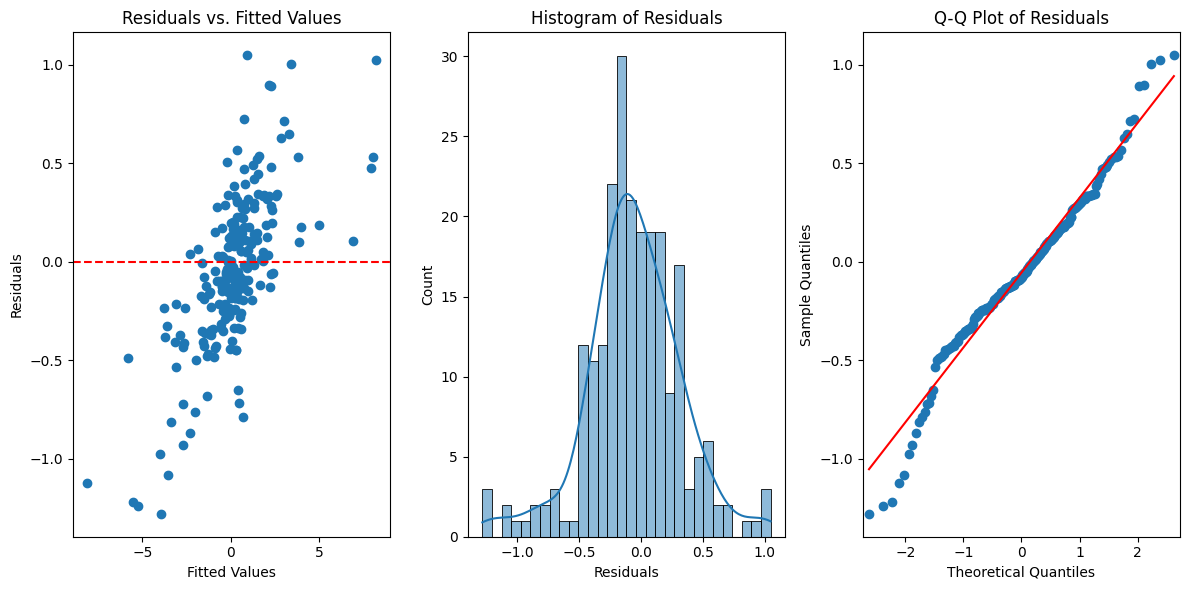

In [24]:

import seaborn as sns
y_pred = catboost_model.predict(X_train)
residuals = y_train - y_pred

# Step 2: Residual vs. Fitted Values Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')

# Step 3: Histogram of Residuals
plt.subplot(1, 3, 2)
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')

# Step 4: Q-Q Plot
plt.subplot(1, 3, 3)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

The above graphs are a sign that the model built is in good order and does not exhibit heteroskadasticity.
1. We see that first graph is random and does not follow any type of pattern.
2. The graph is normally distributed.
3. The Q-Q plot showing the plots closely following the red line is also a good sign.